In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100
plt.style.use("bmh")

In [3]:
os.chdir("../data/")

# Importowanie danych i ich przygotowanie

In [4]:
RANDOM_STATE = 0
TEST_SIZE = 0.2

In [5]:
df = pd.read_csv("totrain.csv", index_col=0)
df = df.drop("dl_polaczenia", axis=1)

In [6]:
X, y = df.drop("target", axis=1), df.target

#### train-test-validate split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_test, X_validate, y_test, y_validate = train_test_split(
    X_test, y_test, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

#### Dlaczego tak
Dzielimy dane na 3 grupy trenowanie i testowanie służa do poprawy modelu, zaś validate do ostatecznego testu jak model się sprawdza

In [8]:
serie = y_train.value_counts()
ratio = {1: serie[0] / serie[1]}
serie

0    21904
1     3097
Name: target, dtype: int64

Ustawiamy ratio ponieważ bardzije nam zależy, żeby model wyszukiwał potencjalne osoby chętne do depozytu

In [9]:
df.head()

,wiek,wyksztalcenie,ma_kredyt,kredyt_mieszkaniowy,ma_pozyczke,miesiac,liczba_polaczen_aktualnej_kampanii,liczba_dni_od_ost_kontaktu,liczba_polaczen_przed_aktualna_kampania,wsk_zmien_zatrudnienia,wsk_cen_konsum,wsk_zauf_konsum,euribor3m,liczba_pracownikow,target,aktywnie_pracujacy,sposob_kontaktu_telephone,stan_cywilny_divorced,stan_cywilny_married,stan_cywilny_single,stan_cywilny_unknown,wynik_poprzedniej_kampanii_failure,wynik_poprzedniej_kampanii_nonexistent,wynik_poprzedniej_kampanii_success,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1.774340,1,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0
1,-0.178868,4,1,0,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
2,0.129533,2,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0
3,1.774340,4,1,1,0,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
4,2.082742,5,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0


## Przygotowanie modeli

In [10]:
def build_model(model, name):
    global X_train, y_train, X_test, y_test, decomp
    plt.figure(dpi=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("-" * 3 + " " + name + " " + "-" * 3)
    print(classification_report(y_test, y_pred))
    print("-" * 10)
    print("Area under curve\n", roc_auc_score(y_test, y_pred))

    fpr, tpr, *_ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)

    print("-" * 10)
    print("Crosstab")
    print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

In [11]:
lr = LogisticRegression(max_iter=10000, class_weight=ratio)
svm = LinearSVC(C=0.0001, class_weight=ratio)
dtc = DecisionTreeClassifier(
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight=ratio,
)
rfc = RandomForestClassifier(
    n_estimators=10000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight=ratio,
)
knn = KNeighborsClassifier(n_neighbors=49)

### Ewaluacja modeli

#### Model najbliższych sąsiadów

--- KNN ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4353
           1       0.70      0.23      0.35       647

    accuracy                           0.89      5000
   macro avg       0.80      0.61      0.64      5000
weighted avg       0.87      0.89      0.86      5000

----------
Area under curve
 0.6085683770470791
----------
Crosstab
Predicted     0    1
Actual              
0          4289   64
1           497  150


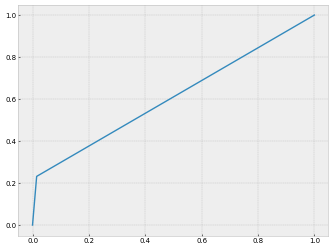

In [12]:
build_model(knn, "KNN")

#### Model benchmark do porównywania inynch

--- LogisticRegression ---
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4353
           1       0.32      0.68      0.44       647

    accuracy                           0.77      5000
   macro avg       0.63      0.73      0.65      5000
weighted avg       0.86      0.77      0.80      5000

----------
Area under curve
 0.7339808286562484
----------
Crosstab
Predicted     0    1
Actual              
0          3423  930
1           206  441


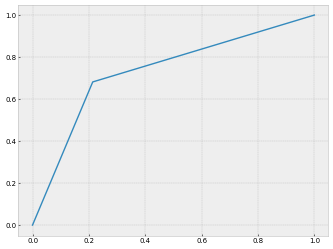

In [13]:
build_model(lr, "LogisticRegression")

#### Model bazujący na wektorach

--- SupportedVectorMachines ---
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4353
           1       0.28      0.73      0.41       647

    accuracy                           0.72      5000
   macro avg       0.62      0.73      0.61      5000
weighted avg       0.86      0.72      0.77      5000

----------
Area under curve
 0.7286685335949447
----------
Crosstab
Predicted     0     1
Actual               
0          3148  1205
1           172   475


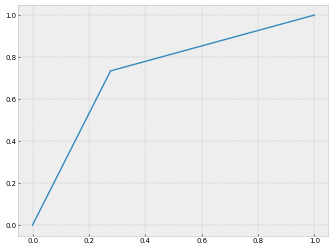

In [14]:
build_model(svm, "SupportedVectorMachines")

#### Drzewo decyzyjne

--- DecisionTreeClassifier ---
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4353
           1       0.39      0.58      0.47       647

    accuracy                           0.83      5000
   macro avg       0.66      0.72      0.68      5000
weighted avg       0.86      0.83      0.84      5000

----------
Area under curve
 0.7246927006939022
----------
Crosstab
Predicted     0    1
Actual              
0          3766  587
1           269  378


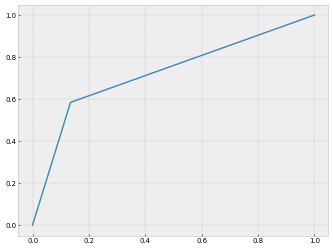

In [15]:
build_model(dtc, "DecisionTreeClassifier")

#### Model wielu drzew decyzyjnych na podstawie losowych zestawów danych

--- RandomForestClassifier ---
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4353
           1       0.53      0.27      0.36       647

    accuracy                           0.87      5000
   macro avg       0.71      0.62      0.64      5000
weighted avg       0.85      0.87      0.86      5000

----------
Area under curve
 0.6177490980478209
----------
Crosstab
Predicted     0    1
Actual              
0          4194  159
1           471  176


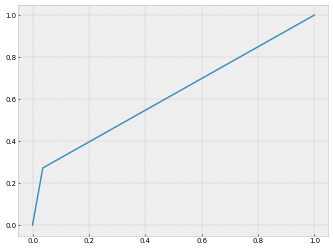

In [16]:
build_model(rfc, "RandomForestClassifier")

#### Na podstawie powyższych wyników, możemy zaobserwować, że najlepszym wyborem będzie algorytm _Decision tree_.
Teraz Szukamy jak najbardziej optymalnych hiperparametrów do drzewa decyzyjnego

In [17]:
n_components = list(range(1, X.shape[1] + 1, 1))
criterion = ["gini", "entropy"]
max_depth = list(range(2, 51, 2))
parameters = dict(
    criterion=criterion,
    max_depth=max_depth,
    class_weight=[ratio],
    max_features=["sqrt", "auto"],
)

In [18]:
gs = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="f1")

#### Walidacja na podstawie wcześniejszego "odłożenia" podzbioru z suffixem _validate_

In [19]:
gs.fit(X_validate, y_validate)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{1: 7.072650952534711}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
                                       44, 46, 48, 50],
                         'max_features': ['sqrt', 'auto']},
             scoring='f1')

In [20]:
gs.best_params_

{'class_weight': {1: 7.072650952534711},
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt'}

--- DCT ---
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      4353
           1       0.38      0.64      0.48       647

    accuracy                           0.82      5000
   macro avg       0.66      0.74      0.68      5000
weighted avg       0.87      0.82      0.84      5000

----------
Area under curve
 0.743575199608293
----------
Crosstab
Predicted     0    1
Actual              
0          3668  685
1           230  417


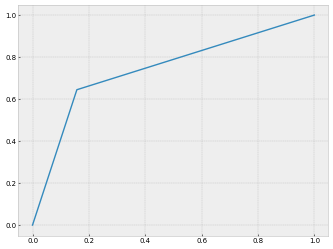

In [226]:
dct = DecisionTreeClassifier(**gs.best_params_)
build_model(dct, "DCT")

#### Ważność konkretnych cech dla modelu

<AxesSubplot:>

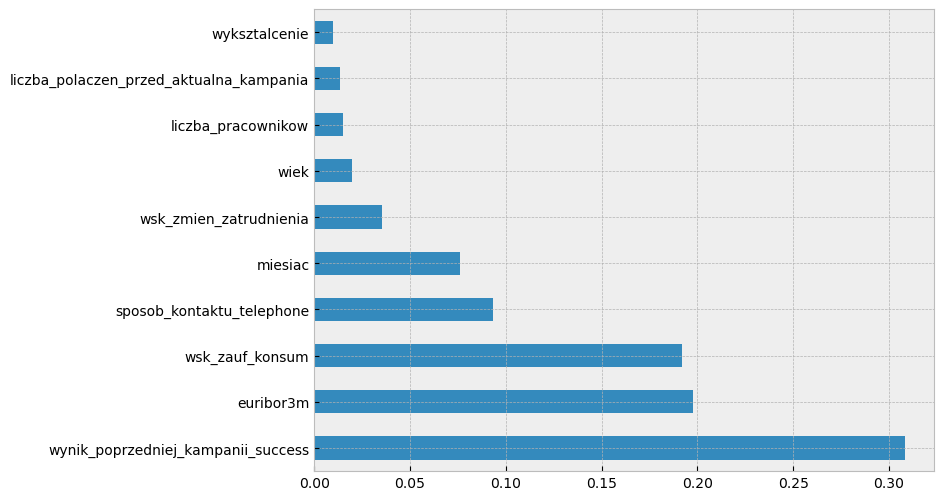

In [23]:
pd.Series(dct.feature_importances_, index=X_validate.columns).nlargest(10).plot(
    kind="barh"
)

# Wnioski

Podstawowe algorytmy do binarnej klasyfikacji, okazały się być niewystarczające. 
- Kosztem większej liczby osób, które najpewniej nie będą chętne złożyć depozytu znaleźniśmy więcej osób, które zaakceptują ofertę depozytu a to na tym nam głównie zależy
- W celu stworzenia najlepszego modelu potrzebne by były informacje jak bardzo chcemy podciągać osoby do grupy, która potencjalnie zaakceptuje depozyt. Ponieważ podciąganie osób do grupy 1 zaawocuje tym, że co prawda zmniejszymy liczbę osób, które zaakceptowałyby ofertę depozytu, ale model zaklasyfikowałby ich jako niechętnych, jednakże spowodowałoby to, że przeprowadzimy więcej bezowocnych rozmów ponieważ podciągniemy też osoby niechętne do depozytu jako chętne


## Co możnaby zrobić inaczej?

Przede wszystkim, należałoby jeszcze raz przeprowadzić proces czyszczenia danych i proces inżynierii cech. Jest parę działań, które popełniliśmy jednak nie byliśmy ich pewni.

- Nie usuwaliśmy żadnego rekordu, nawet dla połączeń trwających 0 sekund, bo założyliśmy, że takie połączenia mogą się zdarzyć.
- Nie usuwaliśmy rekordów, gdzie połączenie trwało powyżej 3000 sekund, bo chcieliśmy przygotować model pod obsługę długich rozmów.
- Można przyjąć _unknown_ jako klasę i nie przybliżać wartości cech, gdzie dana obserwacja, zawiera cechę o wartości _unknown_.
- Należałoby się zastanowić nad cechą _liczba\_dni\_od\_ost\_kontaktu_, gdzie w naszym procesie, klasyfikowaliśmy wartości do zadanych przedziałów, co być może nie jest odpowiednie, bo dla osób, z którymi wcześniej się nie kontaktowano, zaklasyfikowalismy ich do ostatniego przedziału. Takie rozwiązanie, 
- Jeżeli chcielibyśmy uzyskać lepsze wyniki moglibyśmy zostawić kolumnę długości rozmowy z klientem, jednakże wtedy model nie miałby zastosowania w rzeczywistości
- Mogliśmy zmniejszyć ratio podciągania osób granicznych do grupy osób chętnych na depozyt

## Key-takeaways, na co należy zwrócić uwagę przy następnych kampaniach

 - Największe znaczenie w podjęciu decyzji o depozycie ma wskaźnik zmienności zatrudnienia, liczba pracowników i euriborn3m, co oczywiście ma sens, bo przy wysokich stopach procentowych, ludzie nie będą skłonni do odkładania pieniędzy, bo pieniądze tracą na wartości
 - Wartości takie jak wiek czy wykształcenie mają znikomy wpływ na model więc przyszłe kampanie można kierować do szerokiej grupy klientów
 - Warto przy kolejnych kampaniach patrzeć też na wynik poprzedniej kampanii, ponieważ bez względu czy ona się powiodła czy nie, to jej wyniki wypływają na model